# Learning Neural Style Transfer with Tensorflow

## Overview

Neural style transfer is an optimization approach that blends two images, a content picture and a style reference image (such as a famous painter's artwork),o that the output image appears like the content image but "painted" in the manner of the style reference image.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

[![YellowLabradorLooking_new](https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg)](https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg)


---



Yellow Labrador Looking, from Wikimedia Commons by Elf. License CC BY-SA 3.0

[![Wassily Kandinsky art](https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg)](https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg)



---


This is how it would look like if Kandinsky decided to paint the picture of this Dog exclusively with this style.

[![Styled image](https://tensorflow.org/tutorials/generative/images/stylized-image.png)](https://tensorflow.org/tutorials/generative/images/stylized-image.png)


## Setup

#### Download data from [gitlab repository](https://gitlab.com/0x6f736f646f/neuralStyleTransfer)

In [1]:
!git clone https://gitlab.com/0x6f736f646f/neuralStyleTransfer.git
!mv neuralStyleTransfer/data/ .
!mkdir Results/content

Cloning into 'neuralStyleTransfer'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 42 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
mkdir: cannot create directory ‘Results/content’: No such file or directory


#### Import modules

In [2]:
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
import time
import functools

mpl.rcParams['figure.figsize'] = (18, 18)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [3]:
def tensor_to_image(tensor):
  """
  Coverts our tensor object to an image
  """
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#### Define a function to load an image and limit its maximum dimension to 1024 pixels.

In [4]:
def load_img(path_to_img):
  max_dim = 1024
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  # img = img[tf.newaxis, :]
  return img

#### Create a simple function to display an image

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

#### Plot content image and style image

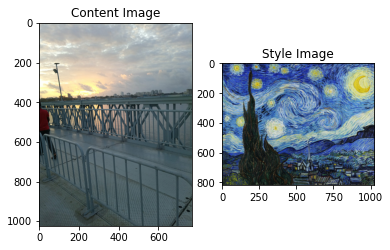

In [6]:
content_image = load_img("/content/data/content/floatingbridgedekz.jpeg")
style_image = load_img("/content/data/style/starynightvangogh.jpg")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer

This exemplifies the original style-transfer method, which optimises picture content for a specific style. Before we dive into the intricacies, let's have a look at how the TensorFlow Hub model does this:

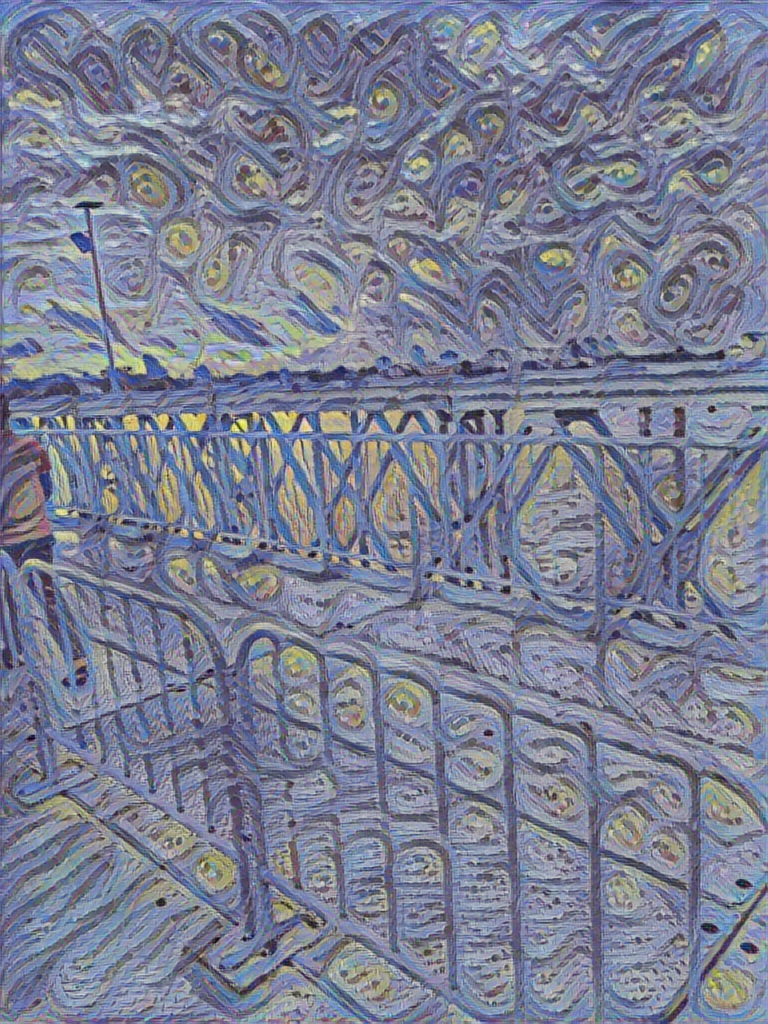

In [7]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image[tf.newaxis, :]), tf.constant(style_image[tf.newaxis, :]))[0]
tensor_to_image(stylized_image)

## Neural Style Transfer

To obtain the image's content and style representations, use the model's intermediate layers. The initial few layer activations, beginning with the network's input layer, indicate low-level properties such as edges and textures. You are employing the VGG19 network design, which is a pretrained image classification network, in this situation. These intermediary layers are required to determine the image's representation of content and style.

Load a VGG19 and test it on our picture to check it's working properly:

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x[tf.newaxis, :])
prediction_probabilities.shape

574726144/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('pier', 0.73044866),
 ('bannister', 0.0763127),
 ('steel_arch_bridge', 0.063366346),
 ('patio', 0.03705384),
 ('breakwater', 0.026605828)]

Now load a VGG19 without the classification head, and list the layer names

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The values of the intermediate feature maps indicate the content of a picture.

It turns out that the means and correlations across the different feature maps may characterise an image's style. Calculate a Gram matrix that contains this information by calculating the feature vector's outer product with itself at each point and averaging that outer product across all locations. This Gram matrix may be constructed for a specific layer as follows:

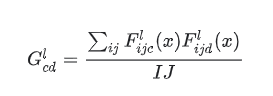


In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j 

### Create the Model

In this scenario, we load [VGG19](https://keras.io/applications/#vgg19) and give the model our input tensor. This will allow us to extract the feature maps of the produced pictures, as well as the content and style representations.

As stated in the study, we utilise VGG19. Furthermore, because VGG19 is a basic model (compared to ResNet, Inception, and others), feature maps function better for style transfer.

To access the intermediate layers corresponding to our style and content feature maps, we obtain the associated outputs and create our model with the necessary output activations using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/).

Declaring a model with the Functional API is as simple as defining the input and output:

`model = Model(inputs, outputs)`

In [12]:
def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
  vgg.trainable = False
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  content_output = vgg.get_layer(content_layers[0]).output 
  style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
  gram_style_output = [gram_matrix(output_) for output_ in style_output]

  model = tf.keras.Model([vgg.input], [content_output, gram_style_output])
  return model

We'll load our pretrained image classification network in the preceding code snippet. Then we grab the layers of interest that we previously identified. Then we define a Model by assigning the model's inputs to an image and its outputs to the style and content layers' outputs. In other words, we built a model that can take an input image and output the content and style of intermediate layers!


### Descent Gradient Run
If you're unfamiliar with gradient descent or need a refresher, this [excellent resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent) is a must-see.

In this example, we apply the Adam optimizer to reduce our loss. We iteratively update our output picture to reduce our loss: rather than updating the weights associated with our network, we train our input image to minimise loss. To do so, we must first understand how we compute our loss and gradients.

* It should be noted that L-BFGS, which is suggested if you are familiar with this technique, is not utilised.

In [13]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

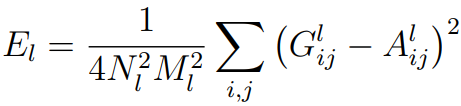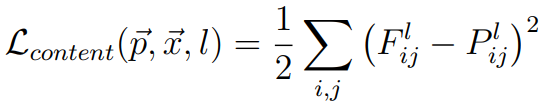

In [14]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
  style_weight = 1e-2
  content_weight = 1e-1
  content_loss = tf.reduce_mean((content_outputs - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss


In [15]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

### Determining the loss and gradients
To compute the gradient, we use [tf.GradientTape](https://www.tensorflow.org/programmers_guide/eager#computing_gradients)  . It enables us to use the automated differentiation provided by tracing operations to compute the gradient later. It records the activities during the forward pass and may subsequently compute the gradient of our loss function with respect to our input picture during the backward phase.

In [16]:
def train_step(image, epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 100 ==0:
    tf.print(f"Loss = {loss}")


In [17]:
EPOCHS = 50
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  train_step(image, i)

Loss = 2480396544.0


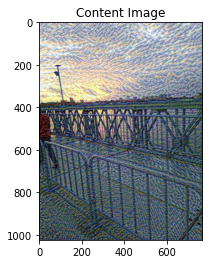

In [18]:
imshow(image, 'Content Image')


# New Section

In [19]:
from neuralStyleTransfer.src.NeuralStyleTransfer import NST

In [20]:
nst = NST(content_path="/content/data/content/techweek.jpg", style_path="/content/data/style/starynightvangogh.jpg", img_height=1024, epochs=100)

In [22]:
nst.run()

Loss = 1666879616.0
Loss = 436211232.0
Loss = 334101952.0
Loss = 214688992.0
Loss = 134746128.0
Loss = 103043560.0
Loss = 89059728.0
Loss = 75104120.0
Loss = 66694812.0
Loss = 59467456.0


In [23]:
nst = NST(content_path="/content/data/content/floatingbridgedekz.jpeg", style_path="/content/data/style/starynightvangogh.jpg", img_height=1024, epochs=100)

In [24]:
nst.run()

Loss = 2480396544.0
Loss = 319297184.0
Loss = 148037952.0
Loss = 100486256.0
Loss = 82014728.0
Loss = 62507248.0
Loss = 53392172.0
Loss = 46814128.0
Loss = 39346332.0
Loss = 34487804.0


In [25]:
# for i in os.listdir("/content/data/content/"):
#   for j in os.listdir("/content/data/style/"):
#     if i != ".ipynb_checkpoints" and j != ".ipynb_checkpoints":
#       print("i: {}\tj: {}".format(i,j))
#       content_path="/content/data/content/{}".format(i)
#       style_path="/content/data/style/{}".format(j)
#       nst = NST(content_path=content_path, style_path=style_path, img_height=1024, epochs=100)
#       nst.run()
# !zip -r /content/Results/content

## Important Takeaways

### Topics covered:

* To reduce these losses, we created multiple distinct loss functions and utilised backpropagation to alter our input image.
* To do this, we have to import a **pretrained model** and apply its learned feature maps to define the content and stylistic representation of our photos.
* Our primary loss functions were largely concerned with determining the distance between these various representations.
* We used the Functional API to build our own model. * We manipulated tensors directly, which makes debugging and dealing with tensors easier. We iteratively modified our picture by utilising **tf.gradient** to update our optimizers' update rules. The optimizer reduced a particular loss in relation to our input picture.